# Preliminaries and Imports

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# system and path set up
import os
import sys

# path
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', 'ColabNotebooks', 'DL','Deep Learning Project Full','DL Team Project', '20251126_22.47_DL_Team_Project_Code_Files_Structure')

# set working directory (for saving/ loading)
os.chdir(GOOGLE_DRIVE_PATH)

# set import path (for importing src/)
sys.path.insert(0, GOOGLE_DRIVE_PATH)

# verify
print("Current working directory:", os.getcwd())
print("Current import directory:", sys.path[0])


Current working directory: /content/drive/My Drive/ColabNotebooks/DL/Deep Learning Project Full/DL Team Project/20251126_22.47_DL_Team_Project_Code_Files_Structure
Current import directory: /content/drive/My Drive/ColabNotebooks/DL/Deep Learning Project Full/DL Team Project/20251126_22.47_DL_Team_Project_Code_Files_Structure


In [3]:
# fetch openai key
# note: previously store your key as secret (key symbol on the left)
from google.colab import userdata
key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = key

# verify
print("Key is in env:", "OPENAI_API_KEY" in os.environ)
print("Check key beginning:", os.environ.get("OPENAI_API_KEY", "")[:10])

Key is in env: True
Check key beginning: sk-proj-X0


In [4]:
# install libraries (only once and then comment out)
# !pip install openai pydantic pandas matplotlib time

In [5]:
# import standard libraries
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json

# import utils
from src import utils

# import model
from src.model_openai_zero_few import OpenAiModelZeroFew

In [6]:
# set seed for reproduceibility (Note: does not work for OpenAI)
seed = 42

# Load and prepare data

In [7]:
# load pre-processed data
csv_path_train_data = f"{GOOGLE_DRIVE_PATH}/data/data_train.csv"
csv_path_val_data = f"{GOOGLE_DRIVE_PATH}/data/data_val.csv"
csv_path_test_data = f"{GOOGLE_DRIVE_PATH}/data/data_test.csv"

train_bal = pd.read_csv(csv_path_train_data)
val = pd.read_csv(csv_path_val_data)
test = pd.read_csv(csv_path_test_data)

In [8]:
# keep only needed columns (drop lang and label5)
train_bal = train_bal.drop(columns=["label5","lang"])
val = val.drop(columns=["label5","lang"])
test = test.drop(columns=["label5","lang"])

In [9]:
# downsample data
# notes:
# - cost incur per input and output token; thus, for this student project we downsample
# - train: no real train data needed; however, few-shot examples taken from train data

val = val.sample(n=2000, random_state=seed)
test = test.sample(n=2000, random_state=seed)

# Run model/ Experiment

Specify model:
- Developer message (for few shot: include examples)
- openai model (e.g., gpt-4.1-mini)

Specify data:
- val data: for tuning
- test data: for final run


In [10]:
# developer message
# Note: Identity, Instructions, Examples (only if few shot), Context (not used here)
developer_message = """
# Identity:

You are a helpful assistant that labels consumer product reviews
as negative, neutral, or positive.

# Instructions:

* Depending on the sentiment in the product review that you are given,
respond with a single word: "negative", "neutral", "positive"
* Do not add an additional comment or formatting to your single word response

# Examples:

<product_review id="example-1">
Brushes all bent. Cheap product — Brushes were all bent. Unable to use product
even if I wanted to. Bottles 1/4 full. Very disappointed.
</product_review>

<assistant_response id="example-1">
negative
</assistant_response>

<product_review id="example-2">
Not worth it — Don’t waste your money… They don’t have a button to actually grab
and close the clasp. The knot on the top is useless.
</product_review>

<assistant_response id="example-2">
negative
</assistant_response>

<product_review id="example-3">
Disappointed in size — Vibrant colors, but not as wide as the pictures represent.
</product_review>

<assistant_response id="example-3">
neutral
</assistant_response>

<product_review id="example-4">
Works well — Love it! A bit inconvenient due to the cord, but overall my hair is
doing better now.
</product_review>

<assistant_response id="example-4">
positive
</assistant_response>

<product_review id="example-5">
Great beard oil — Solved itching completely, smells great, already buying more.
</product_review>

<assistant_response id="example-5">
positive
</assistant_response>
"""

In [11]:
# create instance of model
openai_model = OpenAiModelZeroFew(
    model="gpt-4.1-mini",
    developer_message=developer_message)

# set x and y variables
x = val["text"] # choose from: val["text"], test["text"]
y = val["label3"] # choose from: val["label3"], test["label3"]

# predict with model (meaasuring time)
t0 = time.perf_counter()

pred_txt = openai_model.predict(x, report_interval=100)
pred_num = openai_model.label3_text_to_num(pred_txt)

t1 = time.perf_counter()

Reviews processed: 100
Reviews processed: 200
Reviews processed: 300
Reviews processed: 400
Reviews processed: 500
Reviews processed: 600
Reviews processed: 700
Reviews processed: 800
Reviews processed: 900
Reviews processed: 1000
Reviews processed: 1100
Reviews processed: 1200
Reviews processed: 1300
Reviews processed: 1400
Reviews processed: 1500
Reviews processed: 1600
Reviews processed: 1700
Reviews processed: 1800
Reviews processed: 1900
Reviews processed: 2000


In [12]:
# sanity check: accuracy
acc = sum(y == pred_num) / len(pred_num)
print(f"acc cntrl: {acc}")

acc cntrl: 0.885


# Evaluate Results/ Experiment

In [13]:
# create a run directory (analogous to KP)
hyperparams = {
    "learning_rate": "NA",
    "train_batch_size": "NA",
    "epochs": "NA" }

run_outdir = utils.make_run_dir(
    output_root="outputs",
    model_name="openai_gpt-4.1-mini_zero_shot",
    hyperparams=hyperparams)

print("run_outdir:", run_outdir)

run_outdir: outputs/openai_gpt-4.1-mini_zero_shot_lrNA_bsNA_epNA_20251204_000500


In [14]:
# classification metrics (incl. saving classification report as csv)
metrics = utils.compute_classification_metrics_from_arrays(y_true=y, y_pred=pred_num)
df_cfreport = pd.DataFrame(metrics["classification report"]).T
print(df_cfreport)
path = os.path.join(run_outdir, "classification_report.csv")
df_cfreport.to_csv(path)

              precision    recall  f1-score   support
0              0.832645  0.939394  0.882804   429.000
1              0.392241  0.572327  0.465473   159.000
2              0.993769  0.903683  0.946588  1412.000
accuracy       0.885000  0.885000  0.885000     0.885
macro avg      0.739552  0.805135  0.764955  2000.000
weighted avg   0.911387  0.885000  0.894657  2000.000


<Figure size 600x600 with 0 Axes>

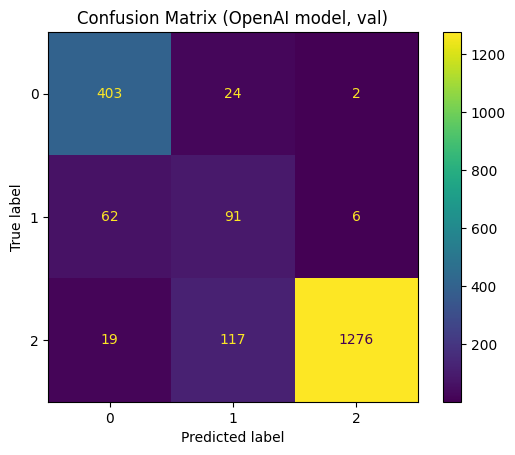

In [15]:
# confusion matrix (incl. saving)
cm = confusion_matrix(y_true=y, y_pred=pred_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix (OpenAI model, val)")
path = os.path.join(run_outdir, "confusion_matrix_openai_val.png")
plt.savefig(path, bbox_inches='tight')
plt.show()

In [16]:
# evaluate time
pred_time_seconds = t1 - t0
pred_time_per_sample = pred_time_seconds / len(pred_num)
print("Prediction time in seconds:", pred_time_seconds)
print("Prediction time per sample:", pred_time_per_sample)

Prediction time in seconds: 4660.060807683
Prediction time per sample: 2.3300304038415


In [17]:
# assess cost (i.e. token used)
input_tokens = openai_model.input_tokens
output_tokens = openai_model.output_tokens
print("Input tokens used:", input_tokens)
print("Output tokens used:", output_tokens)

Input tokens used: 879314
Output tokens used: 12060


In [18]:
# saving results in team_comparison_results
results_comparison = {
    "n_samples": len(x),
    "train_seconds": None,
    "pred_time_seconds": pred_time_seconds,
    "pred_time_per_sample": pred_time_per_sample,
    "metrics": metrics}

utils.save_results_csv(
    results=results_comparison,
    csv_path=os.path.join("outputs", "team_comparison_results.csv"),
    model_name="openai_gpt-4.1-mini_zero_shot",
    extra_info={"run_outdir": run_outdir})

Appended results to outputs/team_comparison_results.csv


In [19]:
# saving all results in dictionary
results_all = results_comparison
results_all["Tokens used"] = {"Input tokens used": input_tokens, "Output tokens used": output_tokens}
results_all["model"] = str(openai_model.model),
results_all["developer_message"] = openai_model.developer_message
path = os.path.join(run_outdir, "results_all.json")
with open(path, "w") as f:
    json.dump(results_all, f, indent=2)
